In [160]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta







In [161]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [162]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [163]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [164]:



df = getQuotes(frameM30)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1577817000,1.12215,1.12308,1.12215,1.12260,1972,7,0
1,1577818800,1.12261,1.12270,1.12224,1.12255,1278,7,0
2,1577820600,1.12255,1.12290,1.12230,1.12285,925,8,0
3,1577822400,1.12287,1.12287,1.12234,1.12241,631,7,0
4,1577824200,1.12242,1.12250,1.12222,1.12229,342,8,0
...,...,...,...,...,...,...,...,...
45653,1693238400,1.08099,1.08128,1.08008,1.08051,2742,9,0
45654,1693240200,1.08051,1.08111,1.07988,1.08068,4902,9,0
45655,1693242000,1.08068,1.08090,1.07985,1.08072,4050,9,0
45656,1693243800,1.08072,1.08137,1.08032,1.08052,3242,9,0


In [165]:




def calculateDonchain(df, lookUpPeriod = 50, includeMedian = False):
    df['donchainupper'] = df['high'].rolling(window=lookUpPeriod).max()
    df['donchainlower'] = df['low'].rolling(window=lookUpPeriod).min()
    if includeMedian:
        df['donchainmiddle'] = (df['donchainupper'] + df['donchainlower']) / 2
    return df





In [166]:


lookUpPeriod = 50


df = calculateDonchain(df, lookUpPeriod, True)


df = df.dropna()

df




,time,open,high,low,close,tick_volume,spread,real_volume,donchainupper,donchainlower,donchainmiddle
49,1577991600,1.11659,1.11708,1.11632,1.11701,1155,7,0,1.12308,1.11632,1.119700
50,1577993400,1.11701,1.11714,1.11642,1.11695,925,7,0,1.12290,1.11632,1.119610
51,1577995200,1.11695,1.11709,1.11633,1.11671,1083,7,0,1.12290,1.11632,1.119610
52,1577997000,1.11671,1.11719,1.11661,1.11697,644,8,0,1.12287,1.11632,1.119595
53,1577998800,1.11697,1.11699,1.11672,1.11679,810,8,0,1.12250,1.11632,1.119410
...,...,...,...,...,...,...,...,...,...,...,...
45653,1693238400,1.08099,1.08128,1.08008,1.08051,2742,9,0,1.08414,1.07655,1.080345
45654,1693240200,1.08051,1.08111,1.07988,1.08068,4902,9,0,1.08414,1.07655,1.080345
45655,1693242000,1.08068,1.08090,1.07985,1.08072,4050,9,0,1.08414,1.07655,1.080345
45656,1693243800,1.08072,1.08137,1.08032,1.08052,3242,9,0,1.08414,1.07655,1.080345


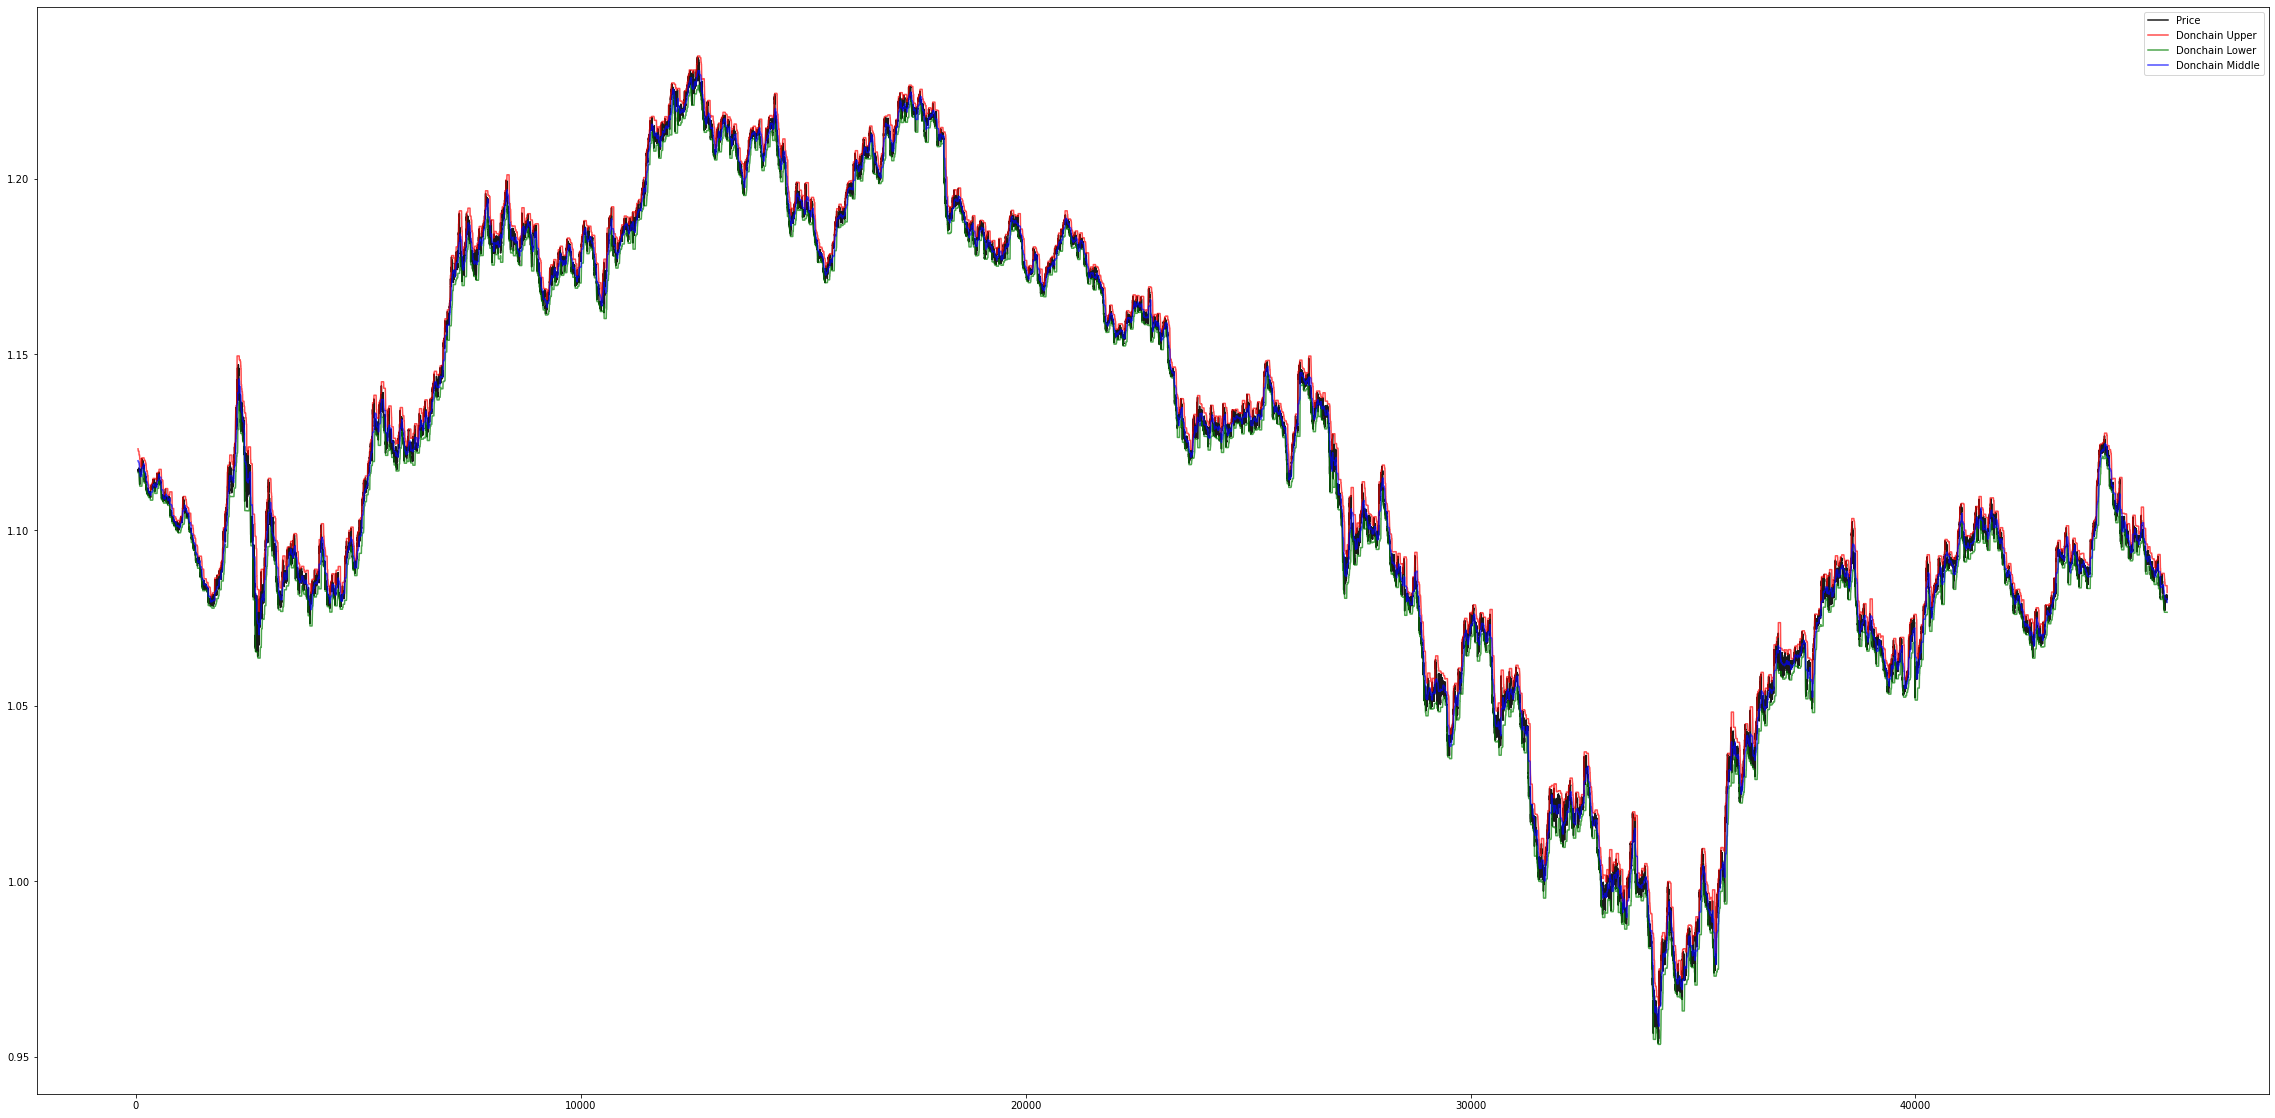

In [167]:








## Increasing the figure size
plt.figure(figsize = (40, 20))

## Plotting the Asset Price.
plt.plot(df['close'], label='Price', c='black', alpha=0.9)

## Plotting the Donchain channels
plt.plot(df['donchainupper'], label='Donchain Upper', c='red', alpha=0.7)
plt.plot(df['donchainlower'], label='Donchain Lower', c='green', alpha=0.7)
plt.plot(df['donchainmiddle'], label='Donchain Middle', c='blue', alpha=0.7)


# Showing the plot
plt.legend()
plt.show()








In [168]:





buyIndices = []
sellIndices = []
buys = []
sells = []
openPosition = None
targetPrice = None
pctRise = 0.01


## Logical Definition
### Given below trading strategy is making use of BreakOut / BreakDown.
### There is also other strategy implementation of Donchain channels that I have done - https://github.com/Sparsh-Kumar/Donchain-Channels-Trading-Strategy-Intraday


for i in range(len(df)):
    if (i > 0) and (openPosition is None) and (df.iloc[i]['close'] > df.iloc[i - 1]['donchainupper']) and (df.iloc[i - 1]['close'] < df.iloc[i - 2]['donchainupper']):
        openPosition = 'long'
        buyIndices.append(i)
        buys.append(df.iloc[i]['close'])
        targetPrice = df.iloc[i]['close'] + (pctRise * df.iloc[i]['close'])
    elif (i > 0) and (openPosition) and (
        #(
        #    (df.iloc[i]['close'] < df.iloc[i -1]['donchainlower']) and
        #    (df.iloc[i - 1]['close'] > df.iloc[i - 2]['donchainlower'])   
        #) or (
            (targetPrice) and
            (df.iloc[i]['close'] >= targetPrice)
        #)
    ):
        openPosition = None
        targetPrice = None
        sellIndices.append(i)
        sells.append(df.iloc[i]['close'])








In [169]:


print(buys)
print(sells)



[1.11929, 1.13286, 1.12254, 1.13684, 1.15122, 1.16425, 1.17471, 1.17942, 1.19568, 1.20803, 1.2227999999999999]
[1.13226, 1.14613, 1.13431, 1.1487, 1.16365, 1.17769, 1.18679, 1.19383, 1.20768, 1.22083]


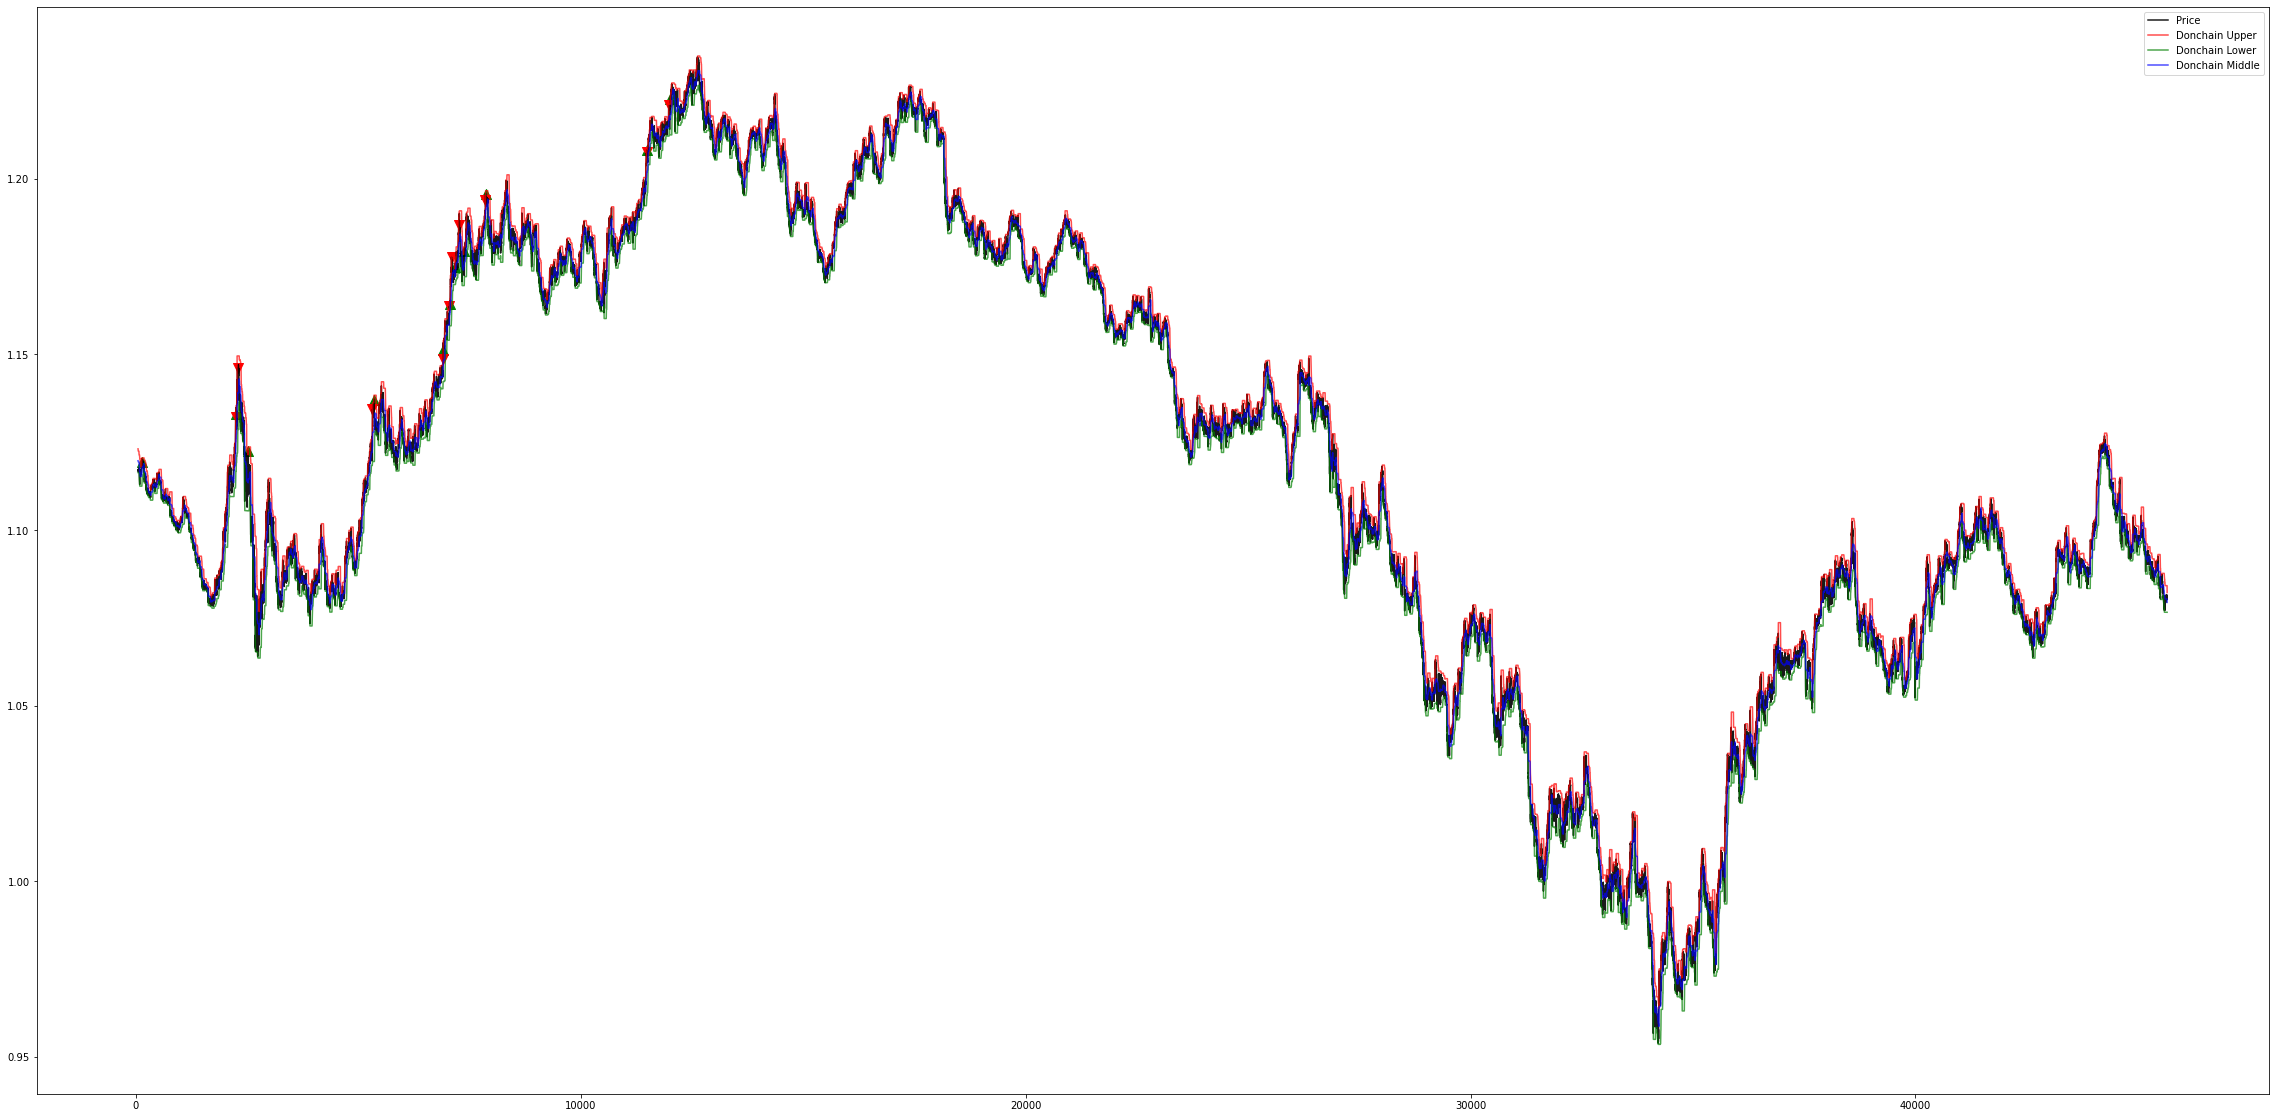

In [170]:











## Increasing the figure size
plt.figure(figsize = (40, 20))

## Plotting the Asset Price.
plt.plot(df['close'], label='Price', c='black', alpha=0.9)

## Plotting the Donchain channels
plt.plot(df['donchainupper'], label='Donchain Upper', c='red', alpha=0.7)
plt.plot(df['donchainlower'], label='Donchain Lower', c='green', alpha=0.7)
plt.plot(df['donchainmiddle'], label='Donchain Middle', c='blue', alpha=0.7)

# Scattering the buy, sell indices
plt.scatter(df.iloc[buyIndices].index, df.iloc[buyIndices]['close'], marker = '^', color = 'g', s = 100)
plt.scatter(df.iloc[sellIndices].index, df.iloc[sellIndices]['close'], marker = 'v', color = 'r', s = 100)

# Showing the plot
plt.legend()
plt.show()














In [171]:






# P & L and other details

totalPL = 0
winTrades = 0
loseTrades = 0
maximumWin = None
maximumLose = None
maximumPercentageWin = None
maximumPercentageLoss = None

for i in range(len(sells)):
    netResult = sells[i] - buys[i]
    maximumValue = max(sells[i], buys[i])
    netResult = netResult - (0.002 * maximumValue);
    percentageWinOrLoss = (netResult / maximumValue) * 100
    message = None

    if netResult < 0:
        loseTrades += 1
        message = f'Lost {percentageWinOrLoss}'
    else:
        winTrades += 1
        message = f'Win {percentageWinOrLoss}'

    if not maximumWin or netResult > maximumWin:
        maximumWin = netResult

    if not maximumLose or netResult < maximumLose:
        maximumLose = netResult

    if not maximumPercentageWin or percentageWinOrLoss > maximumPercentageWin:
        maximumPercentageWin = percentageWinOrLoss

    if not maximumPercentageLoss or percentageWinOrLoss < maximumPercentageLoss:
        maximumPercentageLoss = percentageWinOrLoss

    totalPL = totalPL + netResult
    print(message)

print(f'Total P & L = {totalPL}')
print(f'Win Trades = {winTrades}')
print(f'Lose Trades = {loseTrades}')
print(f'Maximum Win = {maximumWin}')
print(f'Maximum Lose = {maximumLose}')
print(f'Maximum Percentage Win = {maximumPercentageWin}')
print(f'MaximumPercentage Loss = {maximumPercentageLoss}')






Win 0.9454966173847126
Win 0.9578093235496944
Win 0.837635214359376
Win 0.832471489509879
Win 0.8681906071413364
Win 0.9412171284463566
Win 0.8178717380497047
Win 1.0070395282410423
Win 0.7936406995230534
Win 0.8484670265311421
Total P & L = 0.10360626000000041
Win Trades = 10
Lose Trades = 0
Maximum Win = 0.012022340000000034
Maximum Lose = 0.009501379999999837
Maximum Percentage Win = 1.0070395282410423
MaximumPercentage Loss = 0.7936406995230534
